# Explore Data

The natural exploration flow: RadiObject → VolumeCollection → Volume.

**Prerequisites:** Run [00_ingest_brats.ipynb](./00_ingest_brats.ipynb) first.

In [1]:
import shutil
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd

from radiobject import RadiObject, S3Config, configure

# ── Storage URI ──────────────────────────────────────────────────
# Default: S3 (requires AWS credentials)
BRATS_URI = "s3://souzy-scratch/radiobject/brats-tutorial"
# For local storage, comment out the line above and uncomment:
# BRATS_URI = "./data/brats_radiobject"
# ─────────────────────────────────────────────────────────────────

configure(s3=S3Config(region="us-east-2"))

## Load and Explore

In [2]:
radi = RadiObject(BRATS_URI)
print(radi)
print("\n" + radi.describe())

RadiObject(368 subjects, 5 collections: [seg, T2w, FLAIR, T1gd, T1w])



RadiObject Summary
URI: s3://souzy-scratch/radiobject/brats-tutorial
Subjects: 368
Collections: 5

Collections:
  - seg: 368 volumes, shape=240x240x155
  - T2w: 368 volumes, shape=240x240x155
  - FLAIR: 368 volumes, shape=240x240x155
  - T1gd: 368 volumes, shape=240x240x155
  - T1w: 368 volumes, shape=240x240x155


In [3]:
print(f"Collection names: {radi.collection_names}")
print(f"Number of collections: {radi.n_collections}")
print(f"Number of subjects: {len(radi)}")

Collection names: ('seg', 'T2w', 'FLAIR', 'T1gd', 'T1w')
Number of collections: 5
Number of subjects: 368


In [4]:
# Subject-level metadata
radi.obs_meta.read()

,obs_subject_id,age,survival_days,resection_status,dataset,obs_ids
0,BraTS20_Training_001,60.463,289.0,GTR,BraTS2020,"[""BraTS20_Training_001_FLAIR"", ""BraTS20_Traini..."
1,BraTS20_Training_002,52.263,616.0,GTR,BraTS2020,"[""BraTS20_Training_002_FLAIR"", ""BraTS20_Traini..."
2,BraTS20_Training_003,54.301,464.0,GTR,BraTS2020,"[""BraTS20_Training_003_FLAIR"", ""BraTS20_Traini..."
3,BraTS20_Training_004,39.068,788.0,GTR,BraTS2020,"[""BraTS20_Training_004_FLAIR"", ""BraTS20_Traini..."
4,BraTS20_Training_005,68.493,465.0,GTR,BraTS2020,"[""BraTS20_Training_005_FLAIR"", ""BraTS20_Traini..."
...,...,...,...,...,...,...
363,BraTS20_Training_365,NaN,NaN,,BraTS2020,"[""BraTS20_Training_365_FLAIR"", ""BraTS20_Traini..."
364,BraTS20_Training_366,72.000,633.0,GTR,BraTS2020,"[""BraTS20_Training_366_FLAIR"", ""BraTS20_Traini..."
365,BraTS20_Training_367,60.000,437.0,STR,BraTS2020,"[""BraTS20_Training_367_FLAIR"", ""BraTS20_Traini..."
366,BraTS20_Training_368,49.000,442.0,GTR,BraTS2020,"[""BraTS20_Training_368_FLAIR"", ""BraTS20_Traini..."


In [5]:
# Select specific columns
radi.obs_meta.read(columns=["obs_subject_id", "resection_status", "age"])

,obs_subject_id,resection_status,age
0,BraTS20_Training_001,GTR,60.463
1,BraTS20_Training_002,GTR,52.263
2,BraTS20_Training_003,GTR,54.301
3,BraTS20_Training_004,GTR,39.068
4,BraTS20_Training_005,GTR,68.493
...,...,...,...
363,BraTS20_Training_365,,NaN
364,BraTS20_Training_366,GTR,72.000
365,BraTS20_Training_367,STR,60.000
366,BraTS20_Training_368,GTR,49.000


## Index and Filter Subjects

In [6]:
# iloc: integer-location indexing
print(f"iloc[0]:       {radi.iloc[0]}")
print(f"iloc[0:3]:     {radi.iloc[0:3]}")
print(f"iloc[[0,2,4]]: {radi.iloc[[0, 2, 4]]}")

# loc: label-based indexing (uses obs_subject_id)
first_id = radi.obs_subject_ids[0]
third_id = radi.obs_subject_ids[2]
print(f"\nloc['{first_id}']:   {radi.loc[first_id]}")
print(f"loc[[first, third]]: {radi.loc[[first_id, third_id]]}")

# Bracket: shorthand for .loc[]
print(f"\nradi['{first_id}']: {radi[first_id]}")

iloc[0]:       RadiObject(1 subjects, 5 collections: [seg, T2w, FLAIR, T1gd, T1w]) (view)
iloc[0:3]:     RadiObject(3 subjects, 5 collections: [seg, T2w, FLAIR, T1gd, T1w]) (view)
iloc[[0,2,4]]: RadiObject(3 subjects, 5 collections: [seg, T2w, FLAIR, T1gd, T1w]) (view)

loc['BraTS20_Training_001']:   RadiObject(1 subjects, 5 collections: [seg, T2w, FLAIR, T1gd, T1w]) (view)
loc[[first, third]]: RadiObject(2 subjects, 5 collections: [seg, T2w, FLAIR, T1gd, T1w]) (view)

radi['BraTS20_Training_001']: RadiObject(1 subjects, 5 collections: [seg, T2w, FLAIR, T1gd, T1w]) (view)


In [7]:
# Boolean mask indexing
meta = radi.obs_meta.read()
mask = (meta["age"] > 40).values

view_filtered = radi.iloc[mask]
print(f"Subjects with age > 40: {len(view_filtered)} of {len(radi)}")

Subjects with age > 40: 224 of 368


In [8]:
# filter(): metadata expression filtering
hgg_filter = "resection_status == 'GTR'"
compound_filter = "resection_status == 'GTR' and age > 40"
print(f"GTR only:       {radi.filter(hgg_filter)}")
print(f"GTR and age>40: {radi.filter(compound_filter)}")

# head/tail/sample
print(f"\nhead(2): {radi.head(2).obs_subject_ids}")
print(f"tail(2): {radi.tail(2).obs_subject_ids}")
print(f"sample(n=3, seed=42): {radi.sample(n=3, seed=42).obs_subject_ids}")

GTR only:       RadiObject(119 subjects, 5 collections: [seg, T2w, FLAIR, T1gd, T1w]) (view)


GTR and age>40: RadiObject(114 subjects, 5 collections: [seg, T2w, FLAIR, T1gd, T1w]) (view)

head(2): ['BraTS20_Training_001', 'BraTS20_Training_002']
tail(2): ['BraTS20_Training_368', 'BraTS20_Training_369']
sample(n=3, seed=42): ['BraTS20_Training_033', 'BraTS20_Training_241', 'BraTS20_Training_285']


In [9]:
# select_collections() filters to specific modalities
tumor_view = radi.select_collections(["FLAIR", "T2w"])
print(f"Original: {radi.collection_names} -> Filtered: {tumor_view.collection_names}")

# Chain subject + collection filters
chained = radi.iloc[0:3].select_collections(["FLAIR", "T1w"])
print(f"Chained: subjects={chained.obs_subject_ids}, collections={chained.collection_names}")

Original: ('seg', 'T2w', 'FLAIR', 'T1gd', 'T1w') -> Filtered: ('T2w', 'FLAIR')
Chained: subjects=['BraTS20_Training_001', 'BraTS20_Training_002', 'BraTS20_Training_003'], collections=('FLAIR', 'T1w')


## Work with a Collection

In [10]:
flair = radi.FLAIR  # Attribute access (or radi.collection("FLAIR"))

print(f"Shape (X, Y, Z): {flair.shape}")
print(f"Number of volumes: {len(flair)}")
print(f"First 3 obs_ids: {flair.obs_ids[:3]}")

Shape (X, Y, Z): (240, 240, 155)
Number of volumes: 368


First 3 obs_ids: ['BraTS20_Training_001_FLAIR', 'BraTS20_Training_002_FLAIR', 'BraTS20_Training_003_FLAIR']


In [11]:
# Volume-level metadata
flair.obs.read(columns=["obs_id", "obs_subject_id", "series_type", "dimensions", "voxel_spacing"])

,obs_subject_id,obs_id,series_type,dimensions,voxel_spacing
0,BraTS20_Training_001,BraTS20_Training_001_FLAIR,FLAIR,"(240, 240, 155)","(1.0, 1.0, 1.0)"
1,BraTS20_Training_002,BraTS20_Training_002_FLAIR,FLAIR,"(240, 240, 155)","(1.0, 1.0, 1.0)"
2,BraTS20_Training_003,BraTS20_Training_003_FLAIR,FLAIR,"(240, 240, 155)","(1.0, 1.0, 1.0)"
3,BraTS20_Training_004,BraTS20_Training_004_FLAIR,FLAIR,"(240, 240, 155)","(1.0, 1.0, 1.0)"
4,BraTS20_Training_005,BraTS20_Training_005_FLAIR,FLAIR,"(240, 240, 155)","(1.0, 1.0, 1.0)"
...,...,...,...,...,...
363,BraTS20_Training_365,BraTS20_Training_365_FLAIR,FLAIR,"(240, 240, 155)","(1.0, 1.0, 1.0)"
364,BraTS20_Training_366,BraTS20_Training_366_FLAIR,FLAIR,"(240, 240, 155)","(1.0, 1.0, 1.0)"
365,BraTS20_Training_367,BraTS20_Training_367_FLAIR,FLAIR,"(240, 240, 155)","(1.0, 1.0, 1.0)"
366,BraTS20_Training_368,BraTS20_Training_368_FLAIR,FLAIR,"(240, 240, 155)","(1.0, 1.0, 1.0)"


In [12]:
# Same indexing patterns as RadiObject
print(f"iloc[0]:   {flair.iloc[0]}")
print(f"iloc[0:3]: {len(flair.iloc[0:3])} volumes")
print(f"loc['{flair.obs_ids[0]}']: {flair.loc[flair.obs_ids[0]]}")

iloc[0]:   Volume(shape=240x240x155, dtype=int16, obs_id='BraTS20_Training_001_FLAIR')
iloc[0:3]: 3 volumes
loc['BraTS20_Training_001_FLAIR']: Volume(shape=240x240x155, dtype=int16, obs_id='BraTS20_Training_001_FLAIR')


In [13]:
# Iterate over a sample to compute batch statistics
stats = []
for vol in flair.head(5):
    data = vol.to_numpy()
    stats.append({"obs_id": vol.obs_id, "mean": data.mean(), "std": data.std(), "max": data.max()})

pd.DataFrame(stats)

,obs_id,mean,std,max
0,BraTS20_Training_001_FLAIR,26.021916,66.765372,625
1,BraTS20_Training_002_FLAIR,49.390888,114.957089,1091
2,BraTS20_Training_003_FLAIR,43.637505,111.375725,773
3,BraTS20_Training_004_FLAIR,35.865798,85.290033,757
4,BraTS20_Training_005_FLAIR,25.146794,61.172756,762


## Transform Volumes

In [14]:
# .map() applies a transform to each volume and returns an EagerQuery
def normalize(volume, obs):
    return (volume - volume.mean()) / (volume.std() + 1e-8)


flair.head(3).map(normalize).to_list()

[(array([[[-0.38975168, -0.38975168, -0.38975168, ..., -0.38975168,
           -0.38975168, -0.38975168],
          [-0.38975168, -0.38975168, -0.38975168, ..., -0.38975168,
           -0.38975168, -0.38975168],
          [-0.38975168, -0.38975168, -0.38975168, ..., -0.38975168,
           -0.38975168, -0.38975168],
          ...,
          [-0.38975168, -0.38975168, -0.38975168, ..., -0.38975168,
           -0.38975168, -0.38975168],
          [-0.38975168, -0.38975168, -0.38975168, ..., -0.38975168,
           -0.38975168, -0.38975168],
          [-0.38975168, -0.38975168, -0.38975168, ..., -0.38975168,
           -0.38975168, -0.38975168]],
  
         [[-0.38975168, -0.38975168, -0.38975168, ..., -0.38975168,
           -0.38975168, -0.38975168],
          [-0.38975168, -0.38975168, -0.38975168, ..., -0.38975168,
           -0.38975168, -0.38975168],
          [-0.38975168, -0.38975168, -0.38975168, ..., -0.38975168,
           -0.38975168, -0.38975168],
          ...,
          [-

In [15]:
# Transforms can return obs_updates to annotate metadata, then .write() persists
TEMP_DIR = tempfile.mkdtemp(prefix="map_demo_")


def normalize_with_stats(volume, obs):
    mu, sigma = volume.mean(), volume.std()
    return (volume - mu) / (sigma + 1e-8), {
        "pre_norm_mean": float(mu),
        "pre_norm_std": float(sigma),
    }


normed = (
    flair.head(3)
    .map(normalize_with_stats)
    .write(str(Path(TEMP_DIR) / "normed"), name="FLAIR_normed")
)
print(normed)
obs_df = normed.obs.read(columns=["obs_id", "pre_norm_mean", "pre_norm_std"])
shutil.rmtree(TEMP_DIR)
obs_df

VolumeCollection('FLAIR_normed', 3 volumes, shape=heterogeneous)


,obs_subject_id,obs_id,pre_norm_mean,pre_norm_std
0,BraTS20_Training_001,BraTS20_Training_001_FLAIR_normed,26.021916,66.765372
1,BraTS20_Training_002,BraTS20_Training_002_FLAIR_normed,49.390888,114.957089
2,BraTS20_Training_003,BraTS20_Training_003_FLAIR_normed,43.637505,111.375725


In [16]:
# .map_batches() processes volumes in batches for efficiency
def batch_means(batch):
    return [volume.mean() for volume, obs in batch]


flair.head(6).map_batches(batch_means, batch_size=3).to_list()

[(26.021915994623654,
  obs_subject_id                                     BraTS20_Training_001
  obs_id                                       BraTS20_Training_001_FLAIR
  series_type                                                       FLAIR
  voxel_spacing                                           (1.0, 1.0, 1.0)
  dimensions                                              (240, 240, 155)
  datatype                                                              4
  bitpix                                                               16
  scl_slope                                                           1.0
  scl_inter                                                           0.0
  xyzt_units                                                            2
  spatial_units                                                        mm
  qform_code                                                            1
  sform_code                                                            1
  axcodes       

## Read Volume Data

In [17]:
vol = radi.FLAIR.iloc[0]
print(f"Shape: {vol.shape}")
print(f"Data type: {vol.dtype}")
print(f"Observation ID: {vol.obs_id}")

Shape: (240, 240, 155)
Data type: int16
Observation ID: BraTS20_Training_001_FLAIR


In [18]:
# Partial reads — only the requested data is loaded from storage
axial = vol.axial(z=77)
sagittal = vol.sagittal(x=120)
coronal = vol.coronal(y=120)

print(f"Axial shape: {axial.shape}")
print(f"Sagittal shape: {sagittal.shape}")
print(f"Coronal shape: {coronal.shape}")

Axial shape: (240, 240)
Sagittal shape: (240, 155)
Coronal shape: (240, 155)


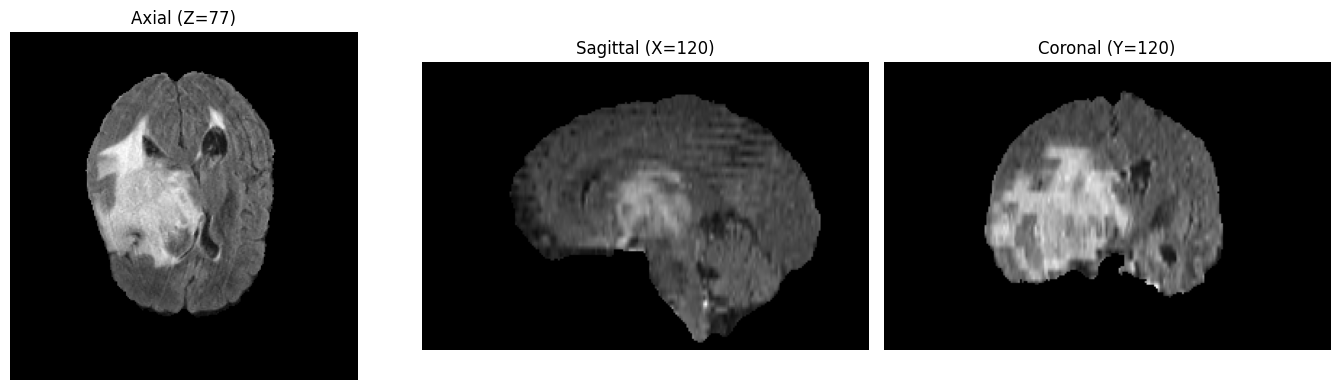

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].imshow(axial.T, cmap="gray", origin="lower")
axes[0].set_title("Axial (Z=77)")

axes[1].imshow(sagittal.T, cmap="gray", origin="lower")
axes[1].set_title("Sagittal (X=120)")

axes[2].imshow(coronal.T, cmap="gray", origin="lower")
axes[2].set_title("Coronal (Y=120)")

for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [20]:
# Arbitrary 3D ROI
roi = vol[50:114, 50:114, 30:94]
print(f"ROI shape: {roi.shape}")

ROI shape: (64, 64, 64)


In [21]:
# Full volume
full_data = vol.to_numpy()
print(f"Shape: {full_data.shape}, Memory: {full_data.nbytes / (1024 * 1024):.2f} MB")

Shape: (240, 240, 155), Memory: 17.03 MB


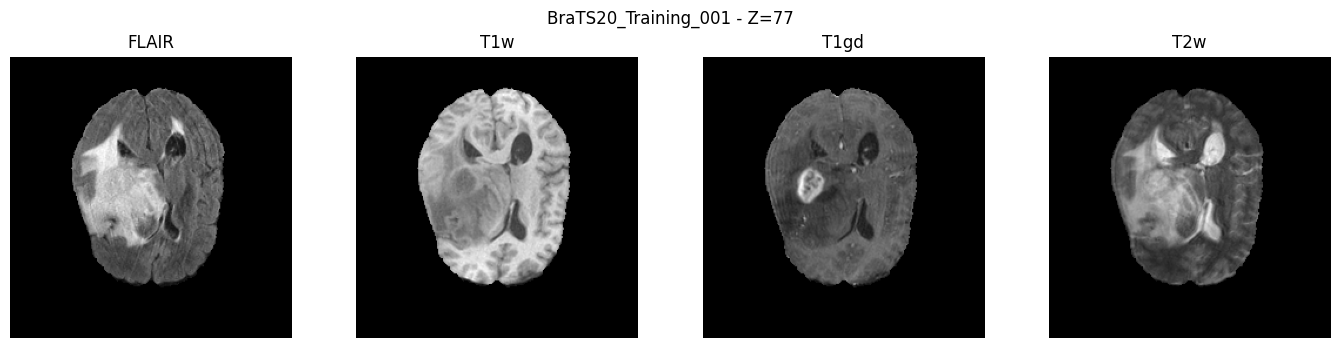

In [22]:
# Compare modalities for one subject
subject_id = radi.obs_subject_ids[0]
z_slice = 77
modalities = ["FLAIR", "T1w", "T1gd", "T2w"]

fig, axes = plt.subplots(1, 4, figsize=(14, 3.5))
for i, mod in enumerate(modalities):
    vol_mod = radi.collection(mod).loc[f"{subject_id}_{mod}"]
    axes[i].imshow(vol_mod.axial(z_slice).T, cmap="gray", origin="lower")
    axes[i].set_title(mod)
    axes[i].axis("off")

plt.suptitle(f"{subject_id} - Z={z_slice}")
plt.tight_layout()
plt.show()

## Analyze and Export

In [23]:
stats = vol.get_statistics(percentiles=[5, 25, 75, 95])

for key, value in stats.items():
    print(f"  {key}: {value:.2f}")

  mean: 26.02
  std: 66.77
  min: 0.00
  max: 625.00
  median: 0.00
  p5: 0.00
  p25: 0.00
  p75: 0.00
  p95: 180.00


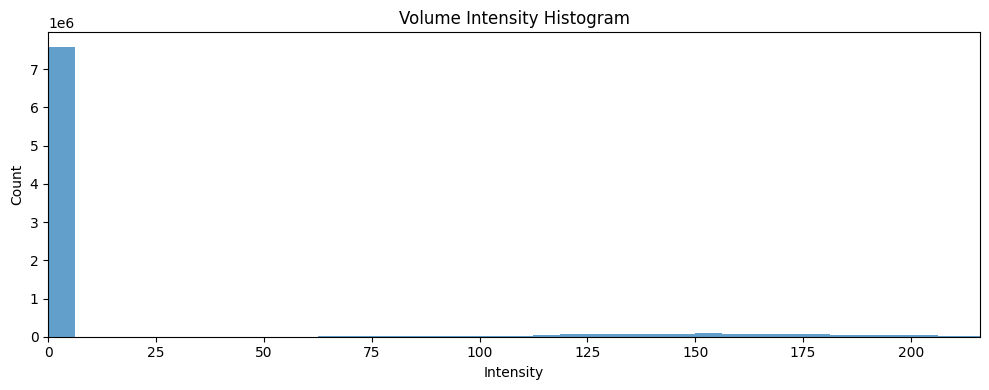

In [24]:
hist_counts, bin_edges = vol.compute_histogram(bins=100)

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(bin_edges[:-1], hist_counts, width=np.diff(bin_edges), align="edge", alpha=0.7)
ax.set_xlabel("Intensity")
ax.set_ylabel("Count")
ax.set_title("Volume Intensity Histogram")
ax.set_xlim(0, stats["p95"] * 1.2)
plt.tight_layout()
plt.show()

In [25]:
# NIfTI round-trip
TEMP_DIR = tempfile.mkdtemp(prefix="vol_demo_")
export_path = Path(TEMP_DIR) / "exported_flair.nii.gz"
vol.to_nifti(export_path)

exported = nib.load(export_path)
print(f"Shape: {exported.shape}")
print(f"Data matches: {np.allclose(vol.to_numpy(), np.asarray(exported.dataobj))}")

shutil.rmtree(TEMP_DIR)

Shape: (240, 240, 155)


Data matches: True


## Views and Persistence

In [26]:
# All filtering operations return views (no data duplication)
view = radi.iloc[0:2]
print(f"is_view: {view.is_view}")

is_view: True


In [27]:
# Write a view to new storage
TEMP_DIR = tempfile.mkdtemp(prefix="radi_demo_")
subset_uri = str(Path(TEMP_DIR) / "subset")
subset_radi = radi.iloc[0:2].select_collections(["FLAIR"]).write(subset_uri)
print(f"Written: {subset_radi}")

# Verify data integrity
orig = radi.FLAIR.iloc[0].axial(z=77)
copy = subset_radi.FLAIR.iloc[0].axial(z=77)
print(f"Data matches: {np.allclose(orig, copy)}")

# Validate the written RadiObject
subset_radi.validate()
print("Validation passed")

shutil.rmtree(TEMP_DIR)

Written: RadiObject(2 subjects, 1 collections: [FLAIR])
Data matches: True


Validation passed


## Next Steps

- [02_configuration.ipynb](./02_configuration.ipynb) - Write settings, read tuning, S3 config
- [03_ingest_msd.ipynb](./03_ingest_msd.ipynb) - Multi-collection ingestion with transforms
- [04_ml_training.ipynb](./04_ml_training.ipynb) - MONAI DataLoader integration